# Data volumes for NBS

In [1]:
import pathlib
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import os
import subprocess
from IPython.display import Markdown as md

import sys
import os
sys.path.append(os.path.abspath('../utils/'))
from shared_functions import get_year_and_month, get_month_name

year, month = get_year_and_month()
month_name = get_month_name(month)

# Create start and end dates
start_date = pd.to_datetime(f'{year}-{month}-01')
end_date = pd.to_datetime(f'{year}-{month + 1}-01') - pd.Timedelta(days=1)  # Last day of the month
last_year = pd.to_datetime(f'{year - 1}-{month + 1}-01') - pd.Timedelta(days=1) # For 1 year of data

plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams.update({'font.size': 22})

In [2]:
# show all rows, all columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

Satellite data storage requires an important amount of disk space, especially high resolution products such as the ones produced by the Sentinel constellation. This also represents an economical cost. Hence, it is very important to keep track of the total volume of data stored at MET Norway premises. In this section those numbers are shown.

## Volumes for AOI backends

Two type of products can be differentiated, products acquired from ESA datahub which keep the original format and Sentinel products transformed into NetCDF-CF. Those directly acquired from ESA are store at MET Norway BE for the AOI. Later on, they are made available to users through colhub-archive and colhub FEs.

In [3]:
logsdir = pathlib.Path('../data')

In [4]:
def read_dhus_logs_details(file):
    data = pd.read_csv(file, header=None, names=['day', 'product_type', 'action', 'volume', 'number', 'timeliness']\
                        , parse_dates=['day'], index_col=['day'])
    return data

In [5]:
data_s1 = read_dhus_logs_details(logsdir / 'S1-backend-AOI_inputs.csv')
data_s2l1c = read_dhus_logs_details(logsdir / 'S2L1C-backend-AOI_inputs.csv')
data_s2l2a = read_dhus_logs_details(logsdir / 'S2L2A-backend-AOI_inputs.csv')
data_s3 = read_dhus_logs_details(logsdir / 'S3-backend-AOI_inputs.csv')
#data_s2dterr = read_dhus_logs_details(logsdir / 'S2DEM-backend-global_inputs.csv')
data_s5 = read_dhus_logs_details(logsdir / 'S5p-backend-AOI_inputs.csv')
all_colhub = pd.concat([data_s1, data_s2l1c, data_s2l2a, data_s3, data_s5])

# Filtering data
all_colhub = all_colhub[
    (all_colhub.index <= end_date)
]

In [6]:
total_vol_be = all_colhub["volume"].sum()/1024

In [7]:
md("The total amount of Sentinel products for the AOI, located in the AOI BE, represents {} TB".format(int(total_vol_be)))

The total amount of Sentinel products for the AOI, located in the AOI BE, represents 4491 TB

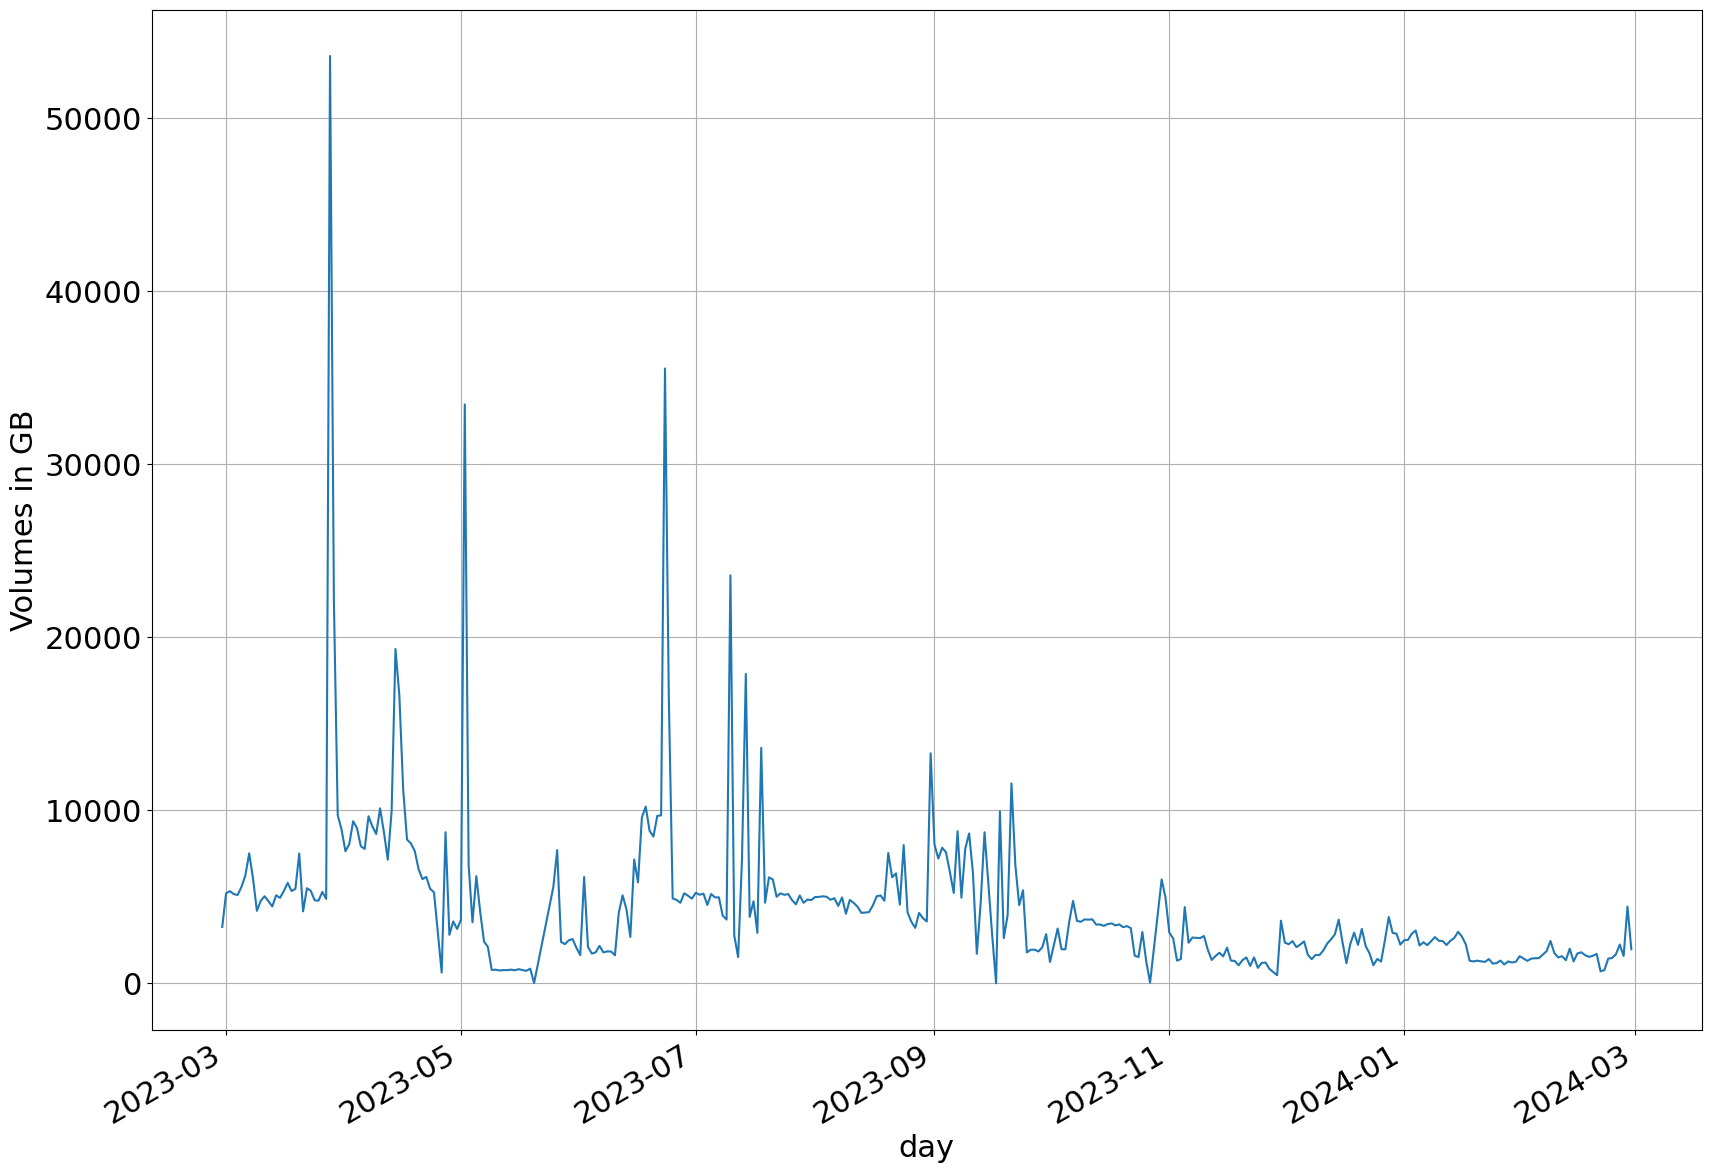

In [8]:
# Last year (volumes in Gb)
# Filtering data
lately = all_colhub[
    (all_colhub.index >= last_year) & 
    (all_colhub.index <= end_date)
]
(lately.groupby(lately.index).sum(numeric_only=True)['volume']).plot(ylabel='Volumes in GB')
plt.grid(True)

In the graphic above the volume of data per day in GB is shown for the last year. Here we can observed seasonality due to optical sensor products. The table below shows the same information for the last month.

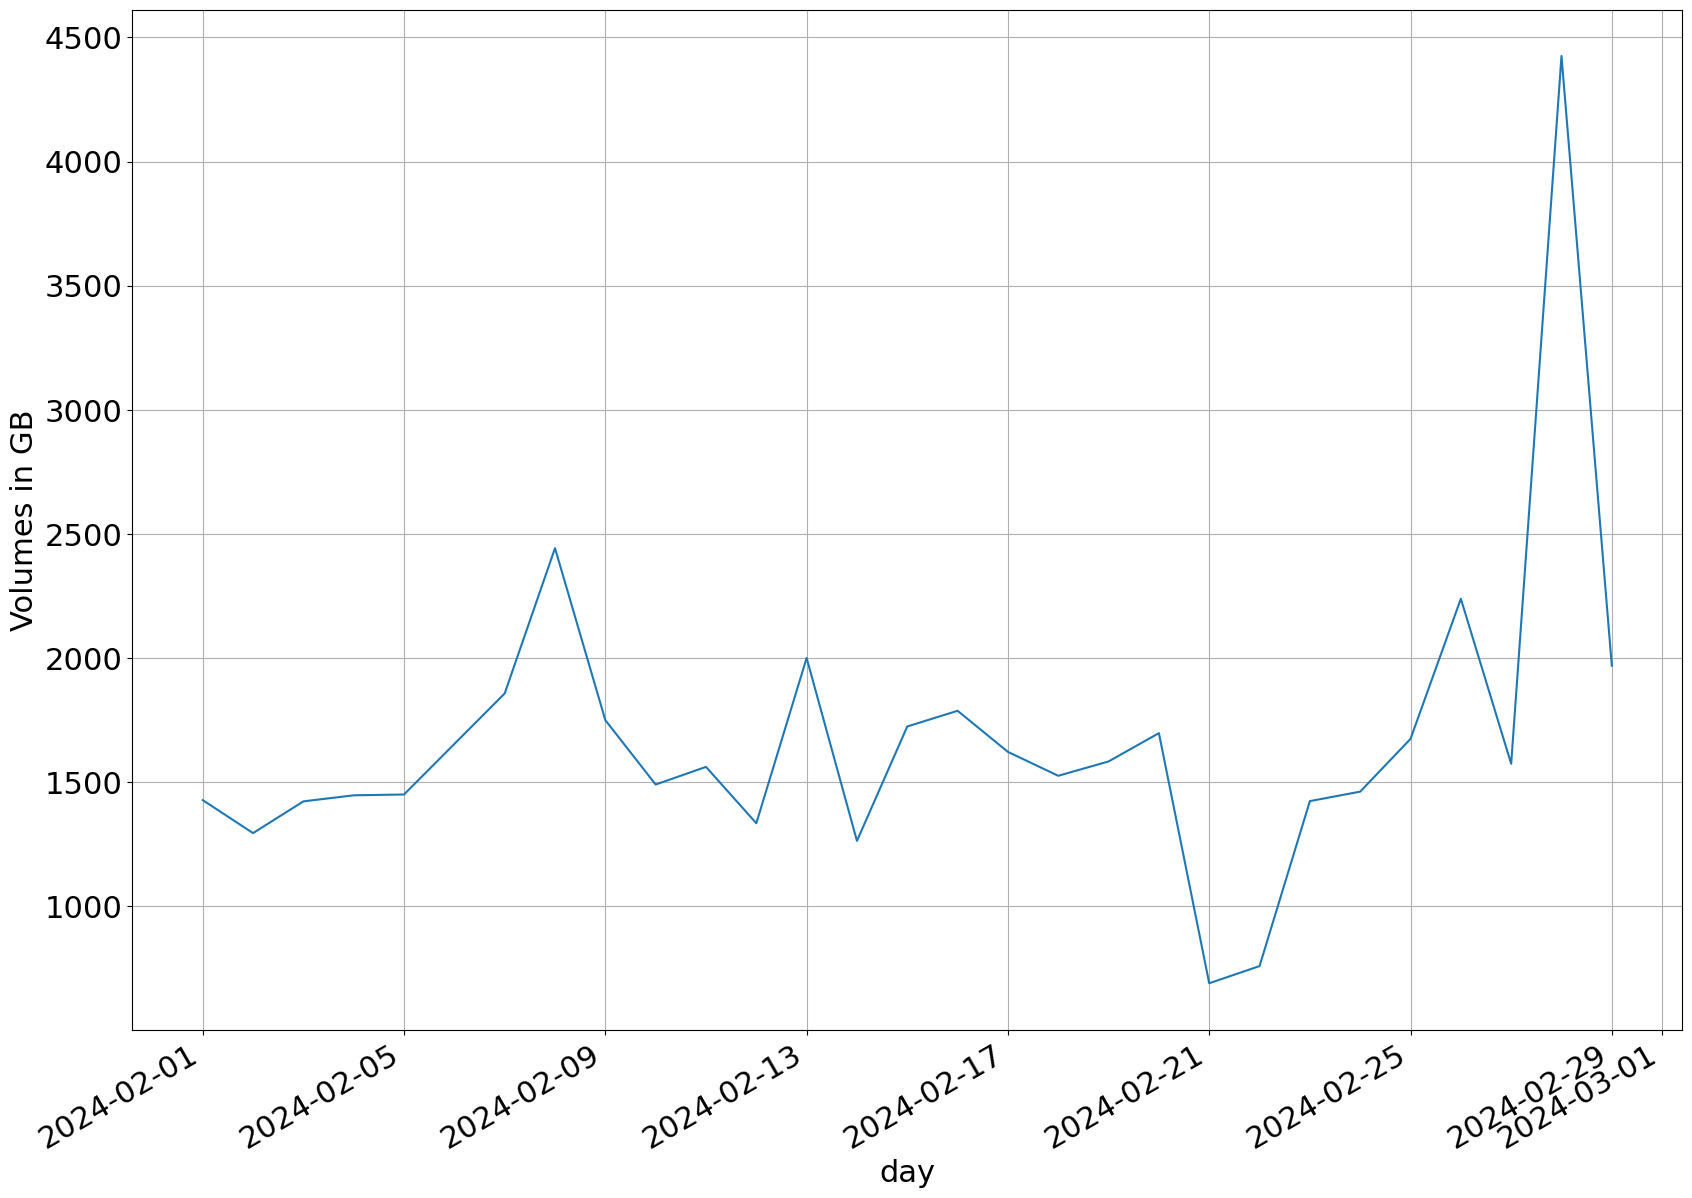

In [9]:
# Last month (volumes in Gb)
lately = all_colhub[
    (all_colhub.index >= start_date) & 
    (all_colhub.index <= end_date)
]
(lately.groupby(lately.index).sum(numeric_only=True)['volume']).plot(ylabel='Volumes in GB')
plt.grid(True)

## Volume for netcdf products

The products converted to NetCDF-CF are S1 and S2 products. These Sentinel datasets are served as SAFE format by ESA. This is not always convenient for users. Therefore as part of the NBS project, one of the MET Norway tasks as operator is to translate those products into NetCDF-CF.

In [10]:
csvfile = pathlib.Path('../data/nb_products_volume_per_sensing_date.csv')

In [11]:
def read_csv(file):
    data_tmp = pd.read_csv(file, header=None, names=['product_type', 'day', 'number', 'volume'], parse_dates=['day'], sep=';')
    # If several sensing date exist, keep the numbers only for the most recent script run (ie highest day index)
    data_clean = copy.deepcopy(data_tmp.drop_duplicates(subset=['product_type', 'day'], keep='last')).set_index('day').sort_index()
    data_clean['volume'] = data_clean['volume']/1024./1024
    return data_clean

In [12]:
all_netcdf = read_csv(csvfile)

In [13]:
# Total volume in Tb
total_nc = all_netcdf.sum()['volume']/1024

In [14]:
md("The total amount of Sentinel-1 and Sentinel-2 products for the AOI transformed to NetCDF represents {} TB".format(int(total_nc)))

The total amount of Sentinel-1 and Sentinel-2 products for the AOI transformed to NetCDF represents 915 TB

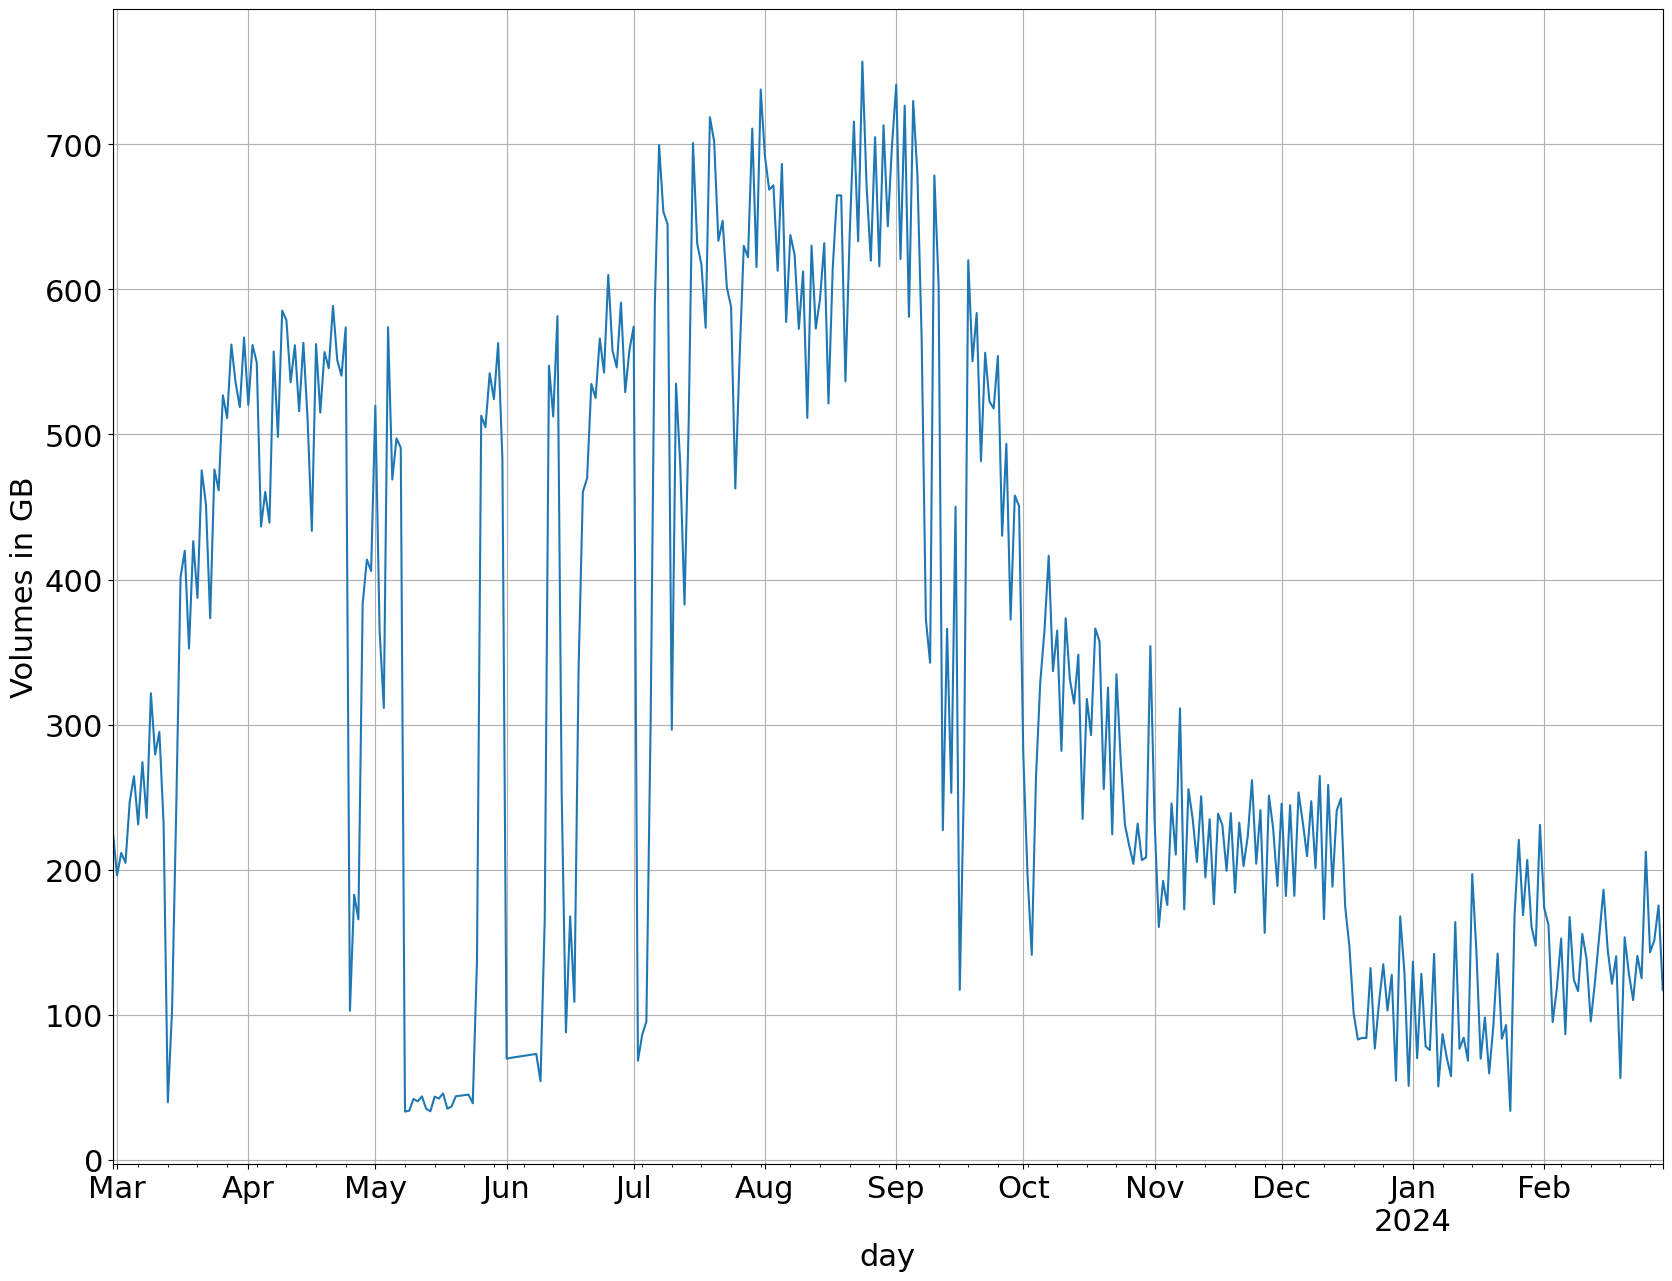

In [15]:
# Last year (volumes in Gb)
lately = all_netcdf[
    (all_netcdf.index >= last_year) & 
    (all_netcdf.index <= end_date)
]
lately.groupby(lately.index).sum(numeric_only=True)['volume'].plot(ylabel='Volumes in GB')
plt.grid(True)

In the graphic above the volume of NetCDF-CF data per day in GB is shown for the last year. Here we can observed seasonality due to optical sensor products. The table below shows the same information for the last 30 days.

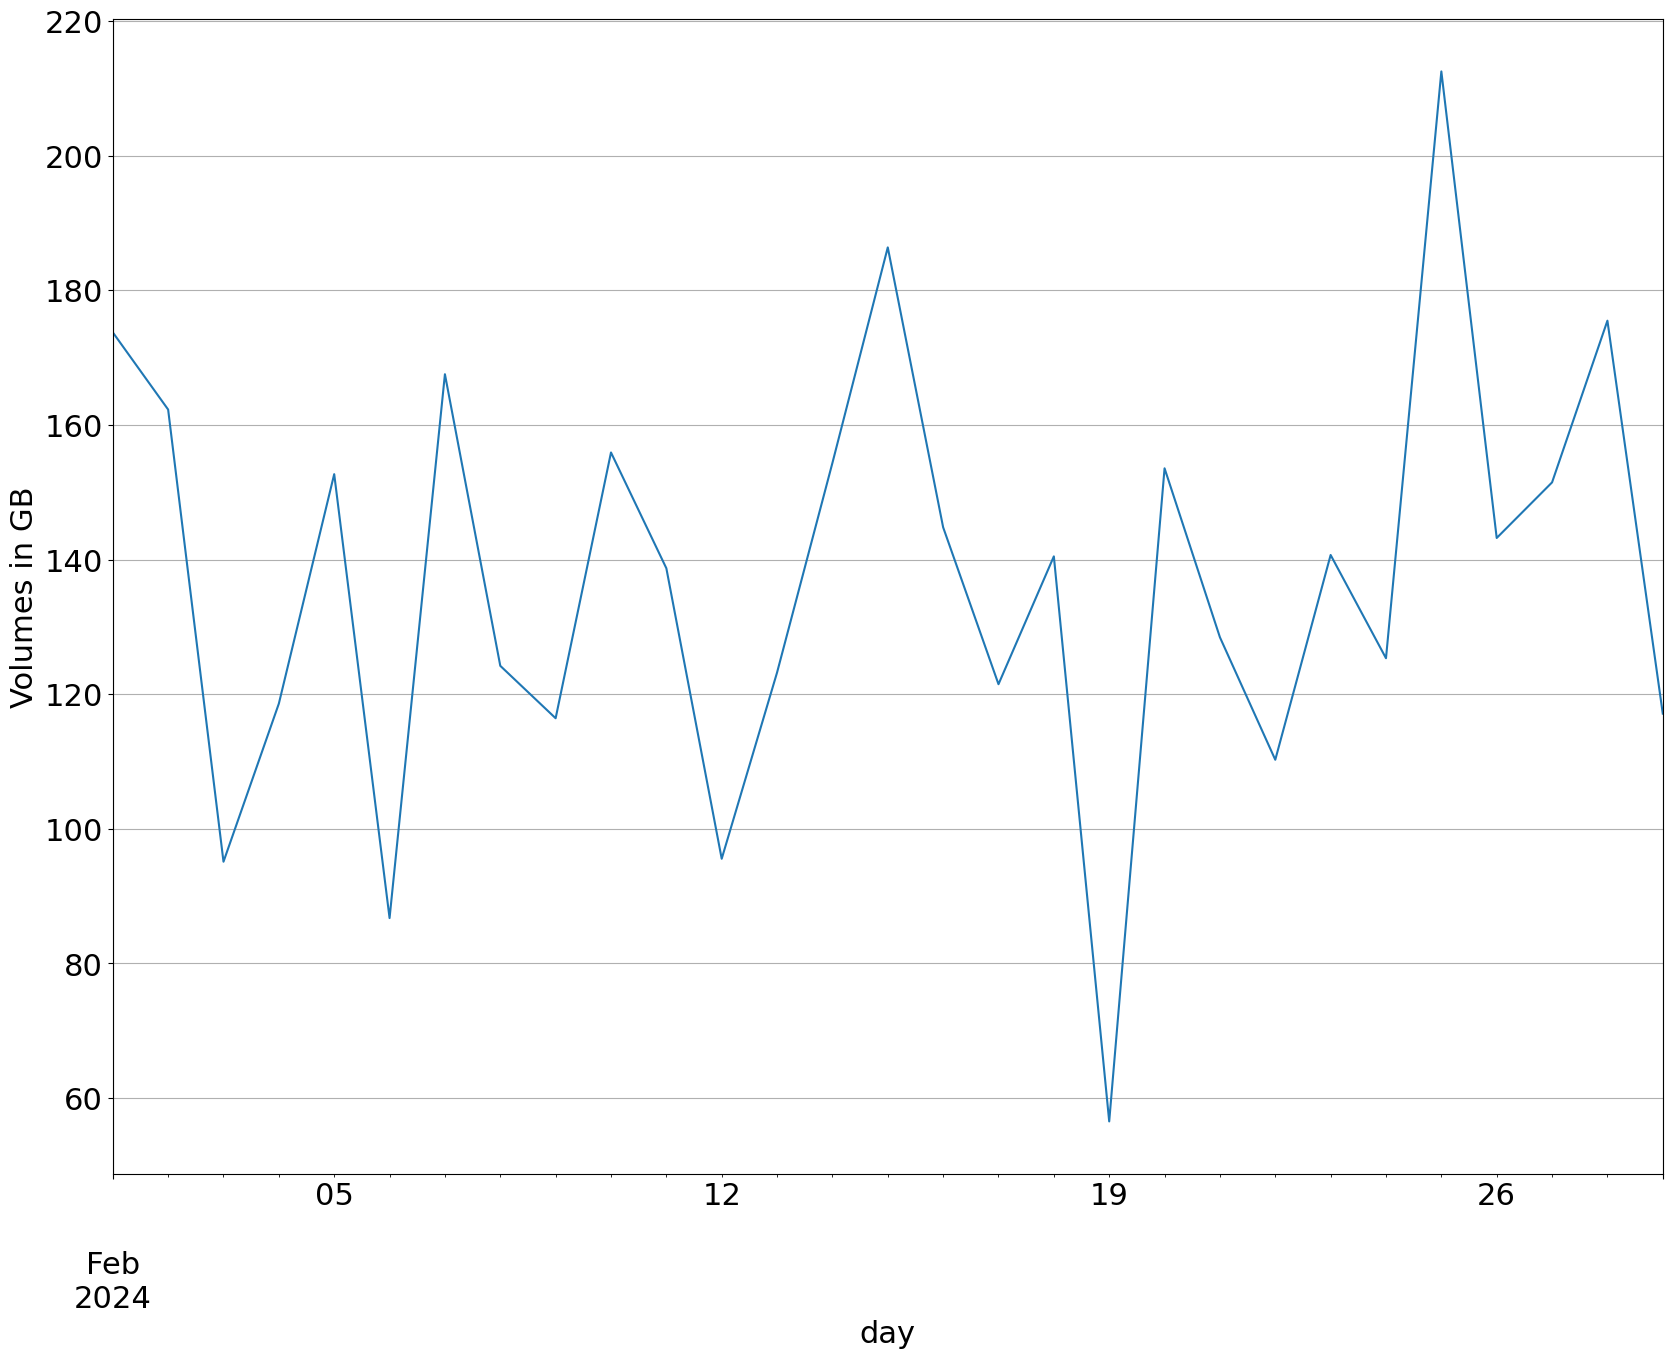

In [16]:
#last month
lately = all_netcdf[
    (all_netcdf.index >= start_date) & 
    (all_netcdf.index <= end_date)
]
lately.groupby(lately.index).sum(numeric_only=True)['volume'].plot(ylabel='Volumes in GB')
plt.grid(True)

## Totals

In [17]:
all_total = pd.concat([all_colhub, all_netcdf])
total_total = total_nc + total_vol_be

In [18]:
md("Finally, the total amount of disk space dedicated to the NBS project, including either products in SAFE and NetCDF formats, represents {} TB".format(int(total_total)))

Finally, the total amount of disk space dedicated to the NBS project, including either products in SAFE and NetCDF formats, represents 5406 TB

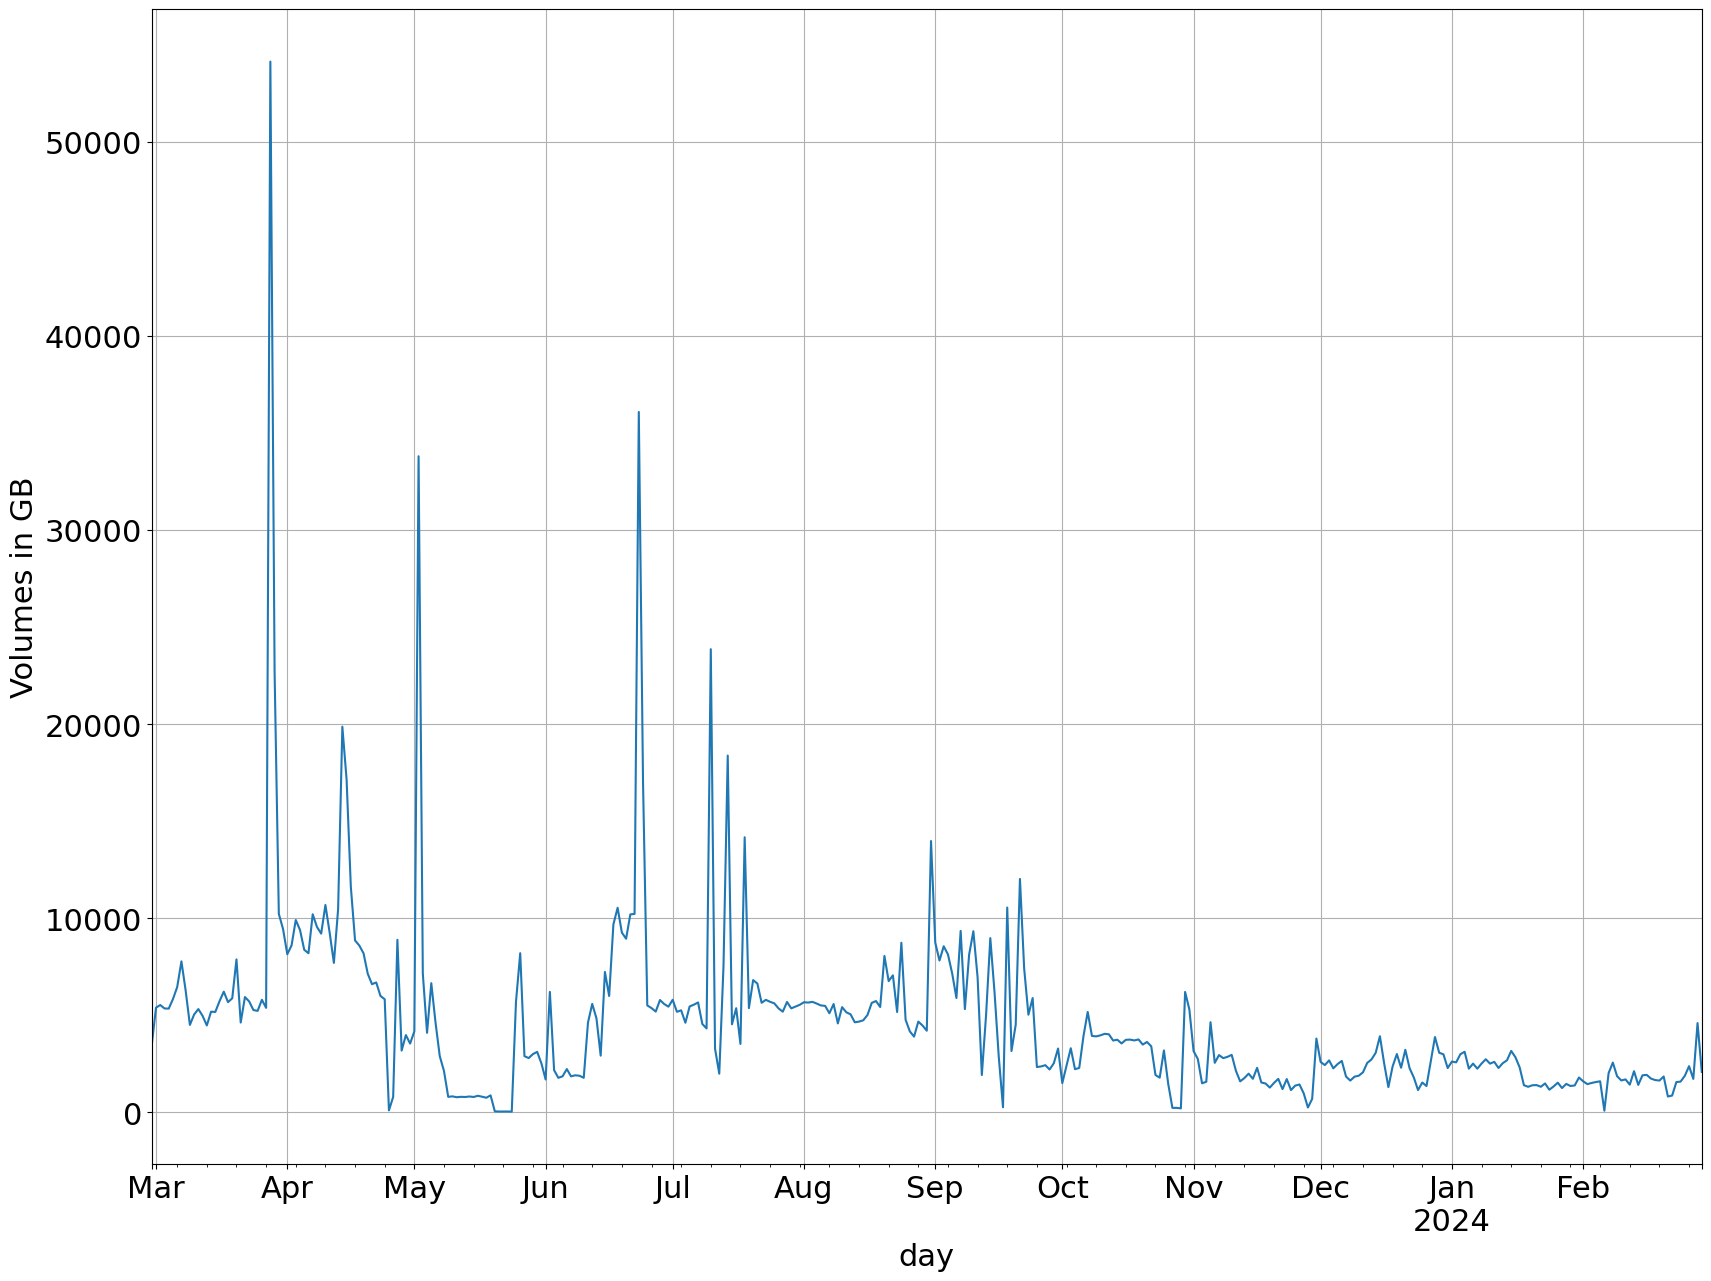

In [19]:
# Last year (volumes in Gb)
lately = all_total[
    (all_total.index >= last_year) & 
    (all_total.index <= end_date)
]
lately.groupby(lately.index).sum(numeric_only=True)['volume'].plot(ylabel='Volumes in GB')
plt.grid(True)

In the graphic above the total volume of data per day in GB is shown for the last year. Here we can observed seasonality due to optical sensor products again. The table below shows the same information for the last month.

In [20]:
# Monthly volumes (in Tb)
lately = all_total[
    (all_total.index >= start_date) & 
    (all_total.index <= end_date)
]
lately.groupby(lately.index.month).sum(numeric_only=True)['volume']/1024.
lately

,product_type,action,volume,number,timeliness
day,,,,,
2024-02-01,GRDH,synchronized,82.877824,50.0,1.239212
2024-02-01,GRDM,synchronized,5.634510,15.0,0.735671
2024-02-01,OCN,synchronized,0.940437,47.0,1.230434
2024-02-01,RAW,synchronized,92.461088,66.0,0.994638
2024-02-01,SLC,synchronized,398.100539,53.0,1.626266
2024-02-02,GRDH,synchronized,82.905269,50.0,1.326327
2024-02-02,GRDM,synchronized,5.112113,13.0,1.902589
2024-02-02,OCN,synchronized,0.943515,49.0,1.468255
2024-02-02,RAW,synchronized,90.822508,64.0,1.084389
